In [1]:
import rpy2.robjects
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as ss
import nibabel as nib
from os import path
from glob import glob
# from nilearn import image as nimage
from nilearn import plotting
from nilearn.input_data import NiftiLabelsMasker
from rpy2.robjects.packages import importr
from rpy2.robjects import pandas2ri

from templateflow import api as tflow

pandas2ri.activate()

try:
    psych = importr('psych')
except:
    utils = importr('utils')
    utils.install_packages('psych', repo="http://cran.rstudio.com/")
    utils.install_packages('GPArotation', repo="http://cran.rstudio.com/")
    psych = importr('psych')


import math as math
import collections

/Users/henrymj/anaconda3/lib/python3.8/site-packages/nilearn/datasets/__init__.py:87: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  warn("Fetchers from the nilearn.datasets module will be "


In [2]:
# CONSTANTS

BASEDIR = '/Users/henrymj/Documents/mounts/OAK/data/uh2/aim1/BIDS_scans/derivatives/2ndlevel'
BASEDIR_EXPANDED = '/Users/henrymj/Documents/mounts/OAK/data/uh2/aim1/BIDS_scans/derivatives/2ndlevel'
esfMRI_PATH = '../../../fmri_data_prep/tpl-MNI152NLin2009cAsym_res-02_atlas-smorgasbord_dseg.nii.gz'

RT_FLAG = True
PARCEL_OPTIONS = ['esfMRI', 400, 1000]
FACTOR_OPTIONS = np.arange(1,11,1) 
SPEC_DICT = {'atlas': 'Schaefer2018',
             'nnetworks': 17,
             'atlas_resolution': 2,
             'space': 'MNI152NLin2009cAsym'}

NNETWORKS = SPEC_DICT['nnetworks']

In [3]:
# DATA CLEANING UTILS
def transform_remove_skew(data, threshold=1, 
                          positive_skewed=None,
                          negative_skewed=None,
                          drop_failed=True,
                          verbose=True):
    data = data.copy()
    if positive_skewed is None:
        positive_skewed = data.skew()>threshold
    if negative_skewed is None:
        negative_skewed = data.skew()<-threshold
    positive_subset = data.loc[:,positive_skewed]
    negative_subset = data.loc[:,negative_skewed]
    # transform variables
    
    # positive skew - log transform
    shift = pd.Series(0, index=positive_subset.columns)
    shift_variables = positive_subset.min()<=0
    shift[shift_variables] -= (positive_subset.min()[shift_variables]-1)
    positive_subset = np.log(positive_subset+shift)
    if drop_failed:
        successful_transforms = positive_subset.loc[:,abs(positive_subset.skew())<threshold]
    else:
        successful_transforms = positive_subset
    if verbose:
        print('*'*40)
        print('** Successfully transformed %s positively skewed variables:' % len(successful_transforms.columns))
        if len(successful_transforms.columns)>0: print('\n'.join(successful_transforms.columns))
    dropped_vars = set(positive_subset)-set(successful_transforms)
    # replace transformed variables
    data.drop(positive_subset, axis=1, inplace = True)
    successful_transforms.columns = [i + '.logTr' for i in successful_transforms]
    if verbose:
        print('*'*40)
        print('Dropping %s positively skewed data that could not be transformed successfully:' % len(dropped_vars))
        if len(dropped_vars)>0: print('\n'.join(dropped_vars))
    data = pd.concat([data, successful_transforms], axis = 1)
    
    # negative skew - reflected log transform
    negative_subset = np.log(negative_subset.max()+1-negative_subset)
    if drop_failed:
        successful_transforms = negative_subset.loc[:,abs(negative_subset.skew())<threshold]
    else:
        successful_transforms = negative_subset
    if verbose:
        print('*'*40)
        print('** Successfully transformed %s negatively skewed variables:' % len(successful_transforms.columns))
        if len(successful_transforms.columns)>0: print('\n'.join(successful_transforms.columns))
    dropped_vars = set(negative_subset)-set(successful_transforms)
    # replace transformed variables
    data.drop(negative_subset, axis=1, inplace = True)
    successful_transforms.columns = [i + '.ReflogTr' for i in successful_transforms]
    if verbose:
        print('*'*40)
        print('Dropping %s negatively skewed data that could not be transformed successfully:' % len(dropped_vars))
        if len(dropped_vars)>0: print('\n'.join(dropped_vars))
    data = pd.concat([data, successful_transforms], axis=1)
    return data.sort_index(axis = 1)

def get_corr_info(parcel_df, corr_thresh = 0.85):

    corr_df = parcel_df.corr()
    corr_df = corr_df.mask(np.equal(*np.indices(corr_df.shape))) #nan diagonal

    corr_info_dict = {
        'above_thresh_counts': (corr_df > corr_thresh).sum(),
        'above_thresh_corr': corr_df[(corr_df > corr_thresh)].sum(),
        'below_thresh_corr': corr_df[(corr_df <= corr_thresh)].mean(),

    }
    corr_info_df = pd.DataFrame.from_dict(corr_info_dict)
    return corr_info_df

def remove_correlated_contrasts(parcel_df, corr_thresh = 0.85, verbose=True):
    parcel_df = parcel_df.copy()

    corr_info_df = get_corr_info(parcel_df)
    problem_cols = []
    while (corr_info_df['above_thresh_counts'] > 0).sum() > 0:
        corr_info_df = corr_info_df.sort_values(by=['above_thresh_counts', 'above_thresh_corr', 'below_thresh_corr'], ascending=False)
        problem_col = corr_info_df.index[0]
        problem_cols.append(problem_col)
        del parcel_df[problem_col]
        corr_info_df = get_corr_info(parcel_df)
    if verbose:
        print('*'*40)
        print(f'Dropping {len(problem_cols)} contrasts which were correlated above {corr_thresh:.2f}')
        print('\t'.join(problem_cols))
        
    return parcel_df

In [4]:
#ASSUMPTION CHECKING HELPERS

# taken from https://github.com/Sarmentor/KMO-Bartlett-Tests-Python/blob/master/correlation.py
def kmo(dataset_corr):
    
    #KMO Test
    #inverse of the correlation matrix
    corr_inv = np.linalg.inv(dataset_corr)
    nrow_inv_corr, ncol_inv_corr = dataset_corr.shape
    
    #partial correlation matrix
    A = np.ones((nrow_inv_corr,ncol_inv_corr))
    for i in range(0,nrow_inv_corr,1):
        for j in range(i,ncol_inv_corr,1):
            #above the diagonal
            A[i,j] = - (corr_inv[i,j]) / (math.sqrt(corr_inv[i,i] * corr_inv[j,j]))
            #below the diagonal
            A[j,i] = A[i,j]
    
    #transform to an array of arrays ("matrix" with Python)
    dataset_corr = np.asarray(dataset_corr)
        
    #KMO value
    kmo_num = np.sum(np.square(dataset_corr)) - np.sum(np.square(np.diagonal(dataset_corr)))
    kmo_denom = kmo_num + np.sum(np.square(A)) - np.sum(np.square(np.diagonal(A)))
    kmo_value = kmo_num / kmo_denom
    
    
    kmo_j = [None]*dataset_corr.shape[1]
    #KMO per variable (diagonal of the spss anti-image matrix)
    for j in range(0, dataset_corr.shape[1]):
        kmo_j_num = np.sum(dataset_corr[:,[j]] ** 2) - dataset_corr[j,j] ** 2
        kmo_j_denom = kmo_j_num + np.sum(A[:,[j]] ** 2) - A[j,j] ** 2
        kmo_j[j] = kmo_j_num / kmo_j_denom

    
    Result = collections.namedtuple("KMO_Test_Results", ["value", "per_variable"])   
    
    #Output of the results - named tuple    
    return Result(value=kmo_value,per_variable=kmo_j)

def check_assumptions(parcel_df, bartlett_thresh=.05, kmo_thresh=0.6):
    sphericity, p_b = ss.bartlett(*[parcel_df[col].values for col in parcel_df.columns])
    if p_b >= bartlett_thresh:
        return (False, p_b, sphericity, np.nan, np.nan)
    kmo_val, kmo_val_per_var = kmo(parcel_df.corr())
    if kmo_val < kmo_thresh:
        return (False, p_b, sphericity, kmo_val, kmo_val_per_var)
    return (True, p_b, sphericity, kmo_val, kmo_val_per_var)

def  describe_assumption_failure(p_b, sphericity, kmo_val, kmo_val_per_var, bartlett_thresh=.05, kmo_thresh=0.6):
    if p_b >= bartlett_thresh:
        print(f'test of bartlett sphericity failed,  {p_b:.03f} >= {bartlett_thresh}; sphericity = {sphericity:.03f}')
    if kmo_val < kmo_thresh:
        print(f'test of kmo failed,  {kmo_val:.03f} < {kmo_thresh}')

In [5]:
## MISC HELPERS

def get_atlas_path(parcel_scheme):
    if type(parcel_scheme)==int:
        atlas_path = tflow.get(SPEC_DICT['space'],
                  desc=f'{parcel_scheme}Parcels{NNETWORKS}Networks',
                  resolution=SPEC_DICT['atlas_resolution'],
                  atlas=SPEC_DICT['atlas'])
        return str(atlas_path)
    elif parcel_scheme=='esfMRI':
        return esfMRI_PATH
    else:
        raise
        

# RRPY2 HELPER
def get_attr(fa, attr='scores'):
    try:
        index = list(fa.names).index(attr)
        val = list(fa.items())[index][1]
        if len(val) == 1:
            val = val[0]
        if type(val)==rpy2.robjects.vectors.Matrix:
            val = np.asarray(val)
        return val
    except ValueError:
        return

# BUILD UP PARCELS PER CONTRAST MAP
def build_parcel_df(beta_maps, atlas_path, split_str='2ndlevel/'):
    assert(type(atlas_path)==str)
    masker = NiftiLabelsMasker(labels_img=atlas_path, standardize=False,
                           memory='nilearn_cache', verbose=0)
        
    parcel_dict = {}
    for beta_map in beta_maps:
        name = beta_map.split(split_str)[-1].split('/')[0]
        contrast = beta_map.split('contrast-')[-1].replace('_2ndlevel-intercept', '').replace('.nii.gz', '')
        img = nib.load(beta_map)
        parcels = masker.fit_transform([img])
        parcel_dict[f'{name}_{contrast}'] = parcels[0]
    parcel_df = pd.DataFrame.from_dict(parcel_dict)
    return parcel_df

# z-scoring for plotting
def min_max_norm(arr):
    
    arr -= np.min(arr)
    arr = arr/(np.max(arr)/2)
    arr -= 1
    
    return arr

def sszscore(arr):
    
    return ss.zscore(arr, ddof=1)


In [6]:
# MAIN FUNCTION

#plot BIC scores

def BIC_plot(info_dict, verbose=True):
    BIC_dict = {}
    most_factors = 0
    for key in info_dict.keys():
        curr_scores = info_dict[key]['BIC']
        BIC_dict[key] = curr_scores
        most_factors = np.max([most_factors, len(curr_scores)])

    #append NANs incase some parcellations ended sooner
    for key in BIC_dict:
        len_diff = most_factors - len(BIC_dict[key])
        BIC_dict[key] += [np.nan]*len_diff

    BIC_dict['nfactors'] = np.arange(1,most_factors+1,1)


    BIC_df = pd.DataFrame.from_dict(BIC_dict)
    BIC_df = BIC_df.set_index('nfactors')
    if verbose:
        for nparcel in PARCEL_OPTIONS:
            row = BIC_df[BIC_df[nparcel]==BIC_df.min()[nparcel]]
            print(nparcel, row.index.values, row[nparcel].values)
    
    BIC_df.columns = BIC_df.columns.astype(str)
    plt.figure(figsize=(12,6))
    _ = sns.lineplot(data=BIC_df)
    plt.show()
    plt.close()
    return BIC_df

def plot_factor_scores(info_dict, parcel_options=['esfMRI'], nfacs=np.arange(1,6,1), standardize=False, standardize_fun=lambda x: x):
    for nparcels in parcel_options:
        atlas_path = get_atlas_path(nparcels)
        
        masker = NiftiLabelsMasker(labels_img=atlas_path, standardize=False,
                               memory='nilearn_cache', verbose=0)
        masker.fit_transform([atlas_path])
        for nfac in nfacs:
            fa_scores = info_dict[nparcels]['scores'][nfac-1]
            for fidx,fa_score in enumerate(fa_scores.T):
                if standardize: fa_score = standardize_fun(fa_score)
                    
                bound = np.max(np.abs(fa_score))    
                weight_img = masker.inverse_transform(np.expand_dims(fa_score, axis=0))
                _ = plotting.plot_img(weight_img, display_mode='z',
                                      cut_coords=[-35, -20, -5, 10, 25, 40, 55, 70],
                                      colorbar=True, cmap='coolwarm',
                                      vmin = -bound,
                                      vmax = bound,
                                      title=f'Solution {nfac} - Factor {fidx+1}')
                plt.show()
                plt.close()

def contrast_EFA(beta_maps, parcel_options=PARCEL_OPTIONS, factor_options=FACTOR_OPTIONS, plot_heatmaps=True, verbose_parcels='esfMRI', check_correlations=True, split_str='2ndlevel/'):    
    
    info_dict = {}
    for nparcels in parcel_options:
        info_dict[nparcels] = {'loadings': [],
                              'scores': [],
                              'BIC': [],
                              'eigenvalues': [],
                              'fa_objs': []}

        atlas_path = get_atlas_path(nparcels)


        parcel_df = build_parcel_df(beta_maps, atlas_path, split_str=split_str)
        parcel_df = transform_remove_skew(parcel_df, verbose=(nparcels==verbose_parcels))
        if check_correlations:
            parcel_df = remove_correlated_contrasts(parcel_df, verbose=(nparcels==verbose_parcels))        
            (assumption_pass, p_b, sphericity, kmo_val, kmo_val_per_var) = check_assumptions(parcel_df)
            if not assumption_pass:
                describe_assumption_failure(p_b, sphericity, kmo_val, kmo_val_per_var)
                continue

        for nfactors in factor_options:
            fa_obj = psych.fa(parcel_df, nfactors,
                              fm='ml',
                              rotate='oblimin',
                              n_obs=len(parcel_df))
            fa_loadings = get_attr(fa_obj, 'loadings')
            fa_scores = get_attr(fa_obj, 'scores')
            fa_BIC = get_attr(fa_obj, 'BIC')
            fa_values = get_attr(fa_obj, 'values')
            if fa_BIC is None:
                break

            info_dict[nparcels]['fa_objs'].append(fa_obj)
            info_dict[nparcels]['eigenvalues'].append(fa_values)
            info_dict[nparcels]['loadings'].append(fa_loadings)
            info_dict[nparcels]['scores'].append(fa_scores)
            info_dict[nparcels]['BIC'].append(fa_BIC)
            
        if plot_heatmaps & (nparcels==verbose_parcels):
            num_hmaps = len(info_dict[verbose_parcels]['loadings'])

            
            if num_hmaps <=4:
                nrows = int(np.floor(np.sqrt(num_hmaps)))
                ncols = int(np.ceil(num_hmaps/nrows))
                fig, axes = plt.subplots(nrows, ncols, figsize=(ncols*12,nrows*8))
            else:
                ncols = np.min([int(np.floor(np.sqrt(num_hmaps))), 3])
                nrows = int(np.ceil(num_hmaps/ncols))
                fig, axes = plt.subplots(nrows, ncols, figsize=(ncols*12,nrows*int(np.ceil(len(parcel_df.columns)/4))))


            for idx, loading in enumerate(info_dict[verbose_parcels]['loadings']):
                loadings_df = pd.DataFrame(loading, index=parcel_df.columns)
                if (ncols==1) or (nrows==1):
                    _ = sns.heatmap(loadings_df, cmap='coolwarm', center=0, ax=axes[idx])
                else:
                    idx_col = idx % ncols
                    idx_row = int(np.floor(idx / ncols))
                    _ = sns.heatmap(loadings_df, cmap='coolwarm', center=0, ax=axes[idx_row, idx_col])
            plt.tight_layout()
            plt.show()
            plt.close()
    return info_dict

In [7]:
def pipeline(maps, factor_options=FACTOR_OPTIONS, split_str='2ndlevel/', check_correlations=True, nfac_plot=np.arange(1,6,1), verbose_parcels='esfMRI'):
    info_dict = contrast_EFA(maps, factor_options=factor_options, split_str=split_str, check_correlations=check_correlations, verbose_parcels=verbose_parcels)
    BIC_df = BIC_plot(info_dict)
    plot_factor_scores(info_dict, nfacs=nfac_plot, parcel_options=[verbose_parcels])
    return info_dict, BIC_df

# Analysis

## EFA relies on the psych package, docs here: https://cran.r-project.org/web/packages/psych/psych.pdf
### Note that rpy2 (which lets you use r package in python) changes names to be pythonic, replacing . with _
#### e.g. fa.parallel -> fa_parallel; n.iter -> n_iter

In [8]:
TASK_MAPS = glob(path.join(BASEDIR_EXPANDED, f'*/*RT-{RT_FLAG}*/*contrast-task_2ndlevel-intercept.nii.gz'))
ALL_MAPS = glob(path.join(BASEDIR_EXPANDED, f'*/*RT-{RT_FLAG}*/*contrast-*2ndlevel-intercept.nii.gz'))

ALL_MAPS_NO_TASK = [m for m in ALL_MAPS if 'contrast-task_2ndlevel-intercept' not in m.split('/')[-1]]
ALL_MAPS_NO_TASK_NO_RT = [m for m in ALL_MAPS_NO_TASK if 'RT' not in m.split('/')[-1]]

RT_MAPS = [m for m in ALL_MAPS if 'RT' in m.split('/')[-1]]
ALL_MAPS_NO_RT = [m for m in ALL_MAPS if 'RT' not in m.split('/')[-1]]

TASK_MAPS

['/Users/henrymj/Documents/mounts/OAK/data/uh2/aim1/BIDS_scans/derivatives/2ndlevel/WATT3/secondlevel-RT-True_beta-False_maps/contrast-task_2ndlevel-intercept.nii.gz',
 '/Users/henrymj/Documents/mounts/OAK/data/uh2/aim1/BIDS_scans/derivatives/2ndlevel/stroop/secondlevel-RT-True_beta-False_maps/contrast-task_2ndlevel-intercept.nii.gz',
 '/Users/henrymj/Documents/mounts/OAK/data/uh2/aim1/BIDS_scans/derivatives/2ndlevel/motorSelectiveStop/secondlevel-RT-True_beta-False_maps/contrast-task_2ndlevel-intercept.nii.gz',
 '/Users/henrymj/Documents/mounts/OAK/data/uh2/aim1/BIDS_scans/derivatives/2ndlevel/ANT/secondlevel-RT-True_beta-False_maps/contrast-task_2ndlevel-intercept.nii.gz',
 '/Users/henrymj/Documents/mounts/OAK/data/uh2/aim1/BIDS_scans/derivatives/2ndlevel/CCTHot/secondlevel-RT-True_beta-False_maps/contrast-task_2ndlevel-intercept.nii.gz',
 '/Users/henrymj/Documents/mounts/OAK/data/uh2/aim1/BIDS_scans/derivatives/2ndlevel/DPX/secondlevel-RT-True_beta-False_maps/contrast-task_2ndlevel-

## Testing FA parallel for get correct number of factors.
## Taking too long locally. will need to be tested on Sherlock!

In [9]:
parcel_options = ['esfMRI']
beta_maps = TASK_MAPS
verbose_parcels = True #400
check_correlations = True
factor_options = [4]

info_dict = {}
nparcels = parcel_options[0]
info_dict[nparcels] = {'loadings': [],
                      'scores': [],
                      'BIC': []}

atlas_path = get_atlas_path(nparcels)


parcel_df = build_parcel_df(beta_maps, atlas_path)
parcel_df = transform_remove_skew(parcel_df, verbose=True)
if check_correlations:
    parcel_df = remove_correlated_contrasts(parcel_df, verbose=True)        
    (assumption_pass, p_b, sphericity, kmo_val, kmo_val_per_var) = check_assumptions(parcel_df)
    if not assumption_pass:
        describe_assumption_failure(p_b, sphericity, kmo_val, kmo_val_per_var)

****************************************
** Successfully transformed 0 positively skewed variables:
****************************************
Dropping 0 positively skewed data that could not be transformed successfully:
****************************************
** Successfully transformed 0 negatively skewed variables:
****************************************
Dropping 0 negatively skewed data that could not be transformed successfully:
****************************************
Dropping 3 contrasts which were correlated above 0.85
motorSelectiveStop_task	twoByTwo_task	stroop_task


In [10]:
# this is the slow part
# parallel_res = psych.fa_parallel(parcel_df,
#                                  fm='ml',
#                                  n_obs=len(parcel_df),
#                                  n_iter=4,
#                                  plot=False)
# parallel_res

# Task > Baseline Contrasts

R[write to console]: Loading required namespace: GPArotation



****************************************
** Successfully transformed 0 positively skewed variables:
****************************************
Dropping 0 positively skewed data that could not be transformed successfully:
****************************************
** Successfully transformed 0 negatively skewed variables:
****************************************
Dropping 0 negatively skewed data that could not be transformed successfully:
****************************************
Dropping 3 contrasts which were correlated above 0.85
motorSelectiveStop_task	twoByTwo_task	stroop_task


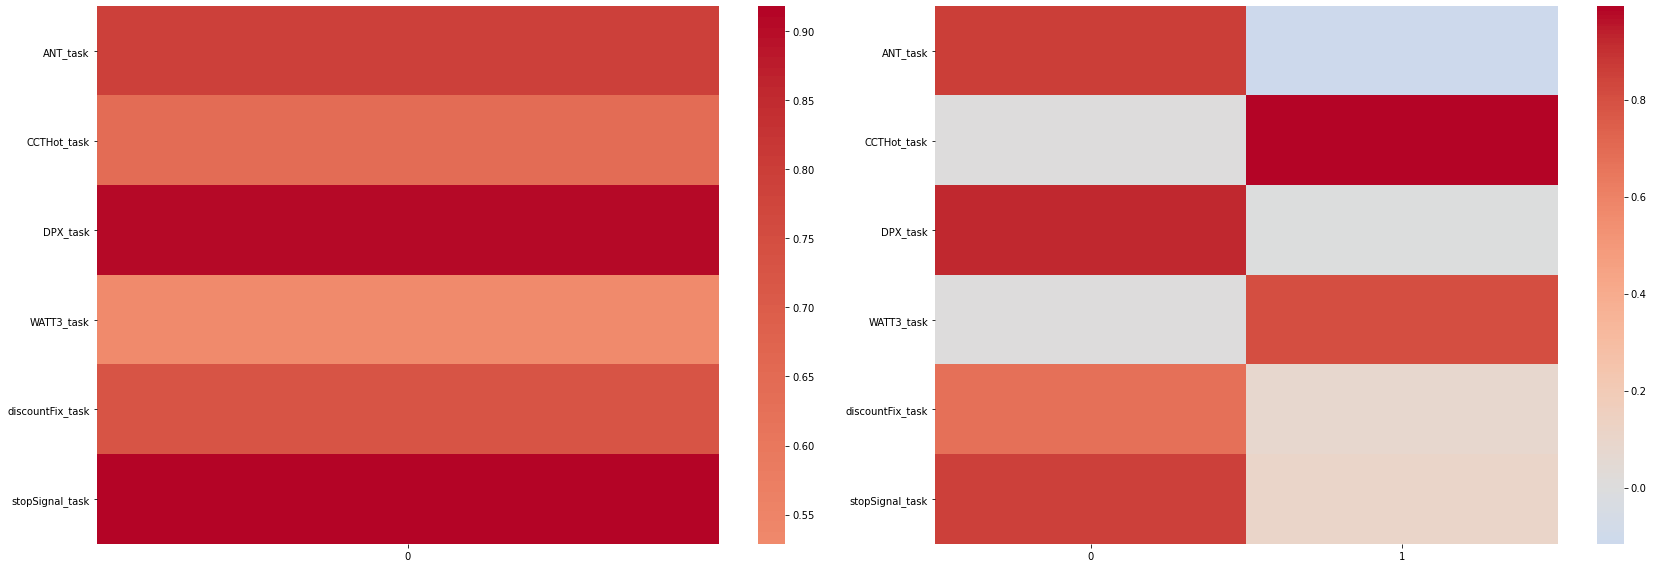

esfMRI [2] [147.53899729]
400 [2] [144.74402774]
1000 [2] [368.89948884]


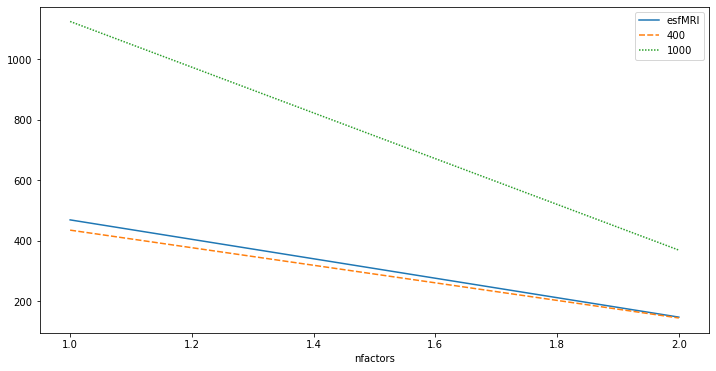

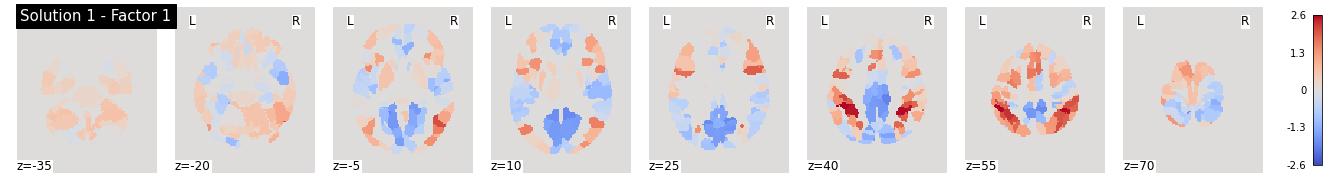

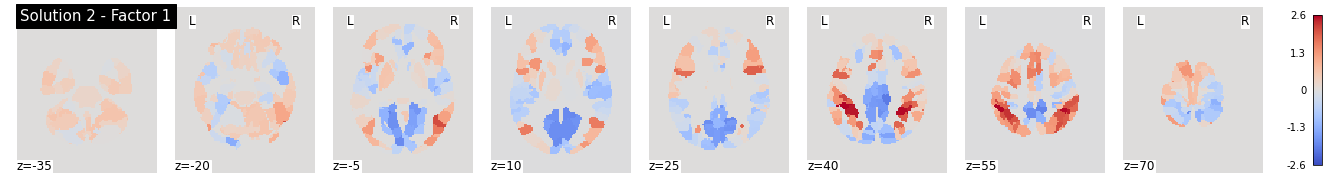

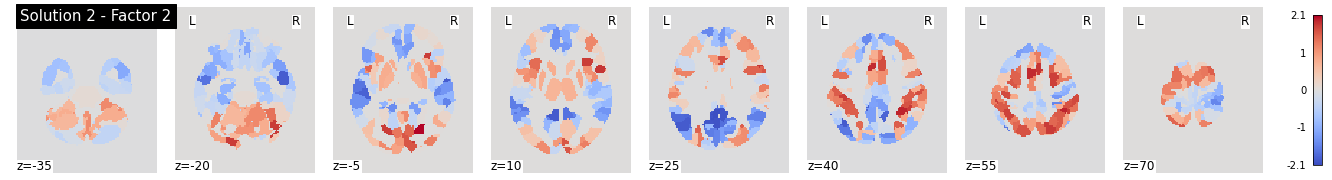

In [11]:
info_dict, BIC_df = pipeline(TASK_MAPS, nfac_plot=[1,2])

In [12]:
get_attr(info_dict['esfMRI']['fa_objs'][1], 'values')

array([ 3.68163759,  0.80854593,  0.18932554,  0.0153016 , -0.04765121,
       -0.13128192])

## ALL CONTRASTS - TASK and RT EXCLUDED

### Only excluding Task fails the KMO test

****************************************
** Successfully transformed 0 positively skewed variables:
****************************************
Dropping 0 positively skewed data that could not be transformed successfully:
****************************************
** Successfully transformed 0 negatively skewed variables:
****************************************
Dropping 0 negatively skewed data that could not be transformed successfully:
****************************************
Dropping 26 contrasts which were correlated above 0.85
stopSignal_stop_success	twoByTwo_cue_stay_100	motorSelectiveStop_noncrit_signal	motorSelectiveStop_crit_stop_success	twoByTwo_cue_stay	twoByTwo_cue_stay_900	DPX_BX	twoByTwo_task_stay_cue_switch	stopSignal_go	twoByTwo_task_switch	twoByTwo_task_switch_900	stopSignal_stop_failure	DPX_AY	twoByTwo_task_stay_cue_switch_100	WATT3_practice	DPX_BY	stopSignal_stop_failure-stop_success	motorSelectiveStop_noncrit_nosignal	twoByTwo_task_switch_100	motorSelectiveStop_crit_sto

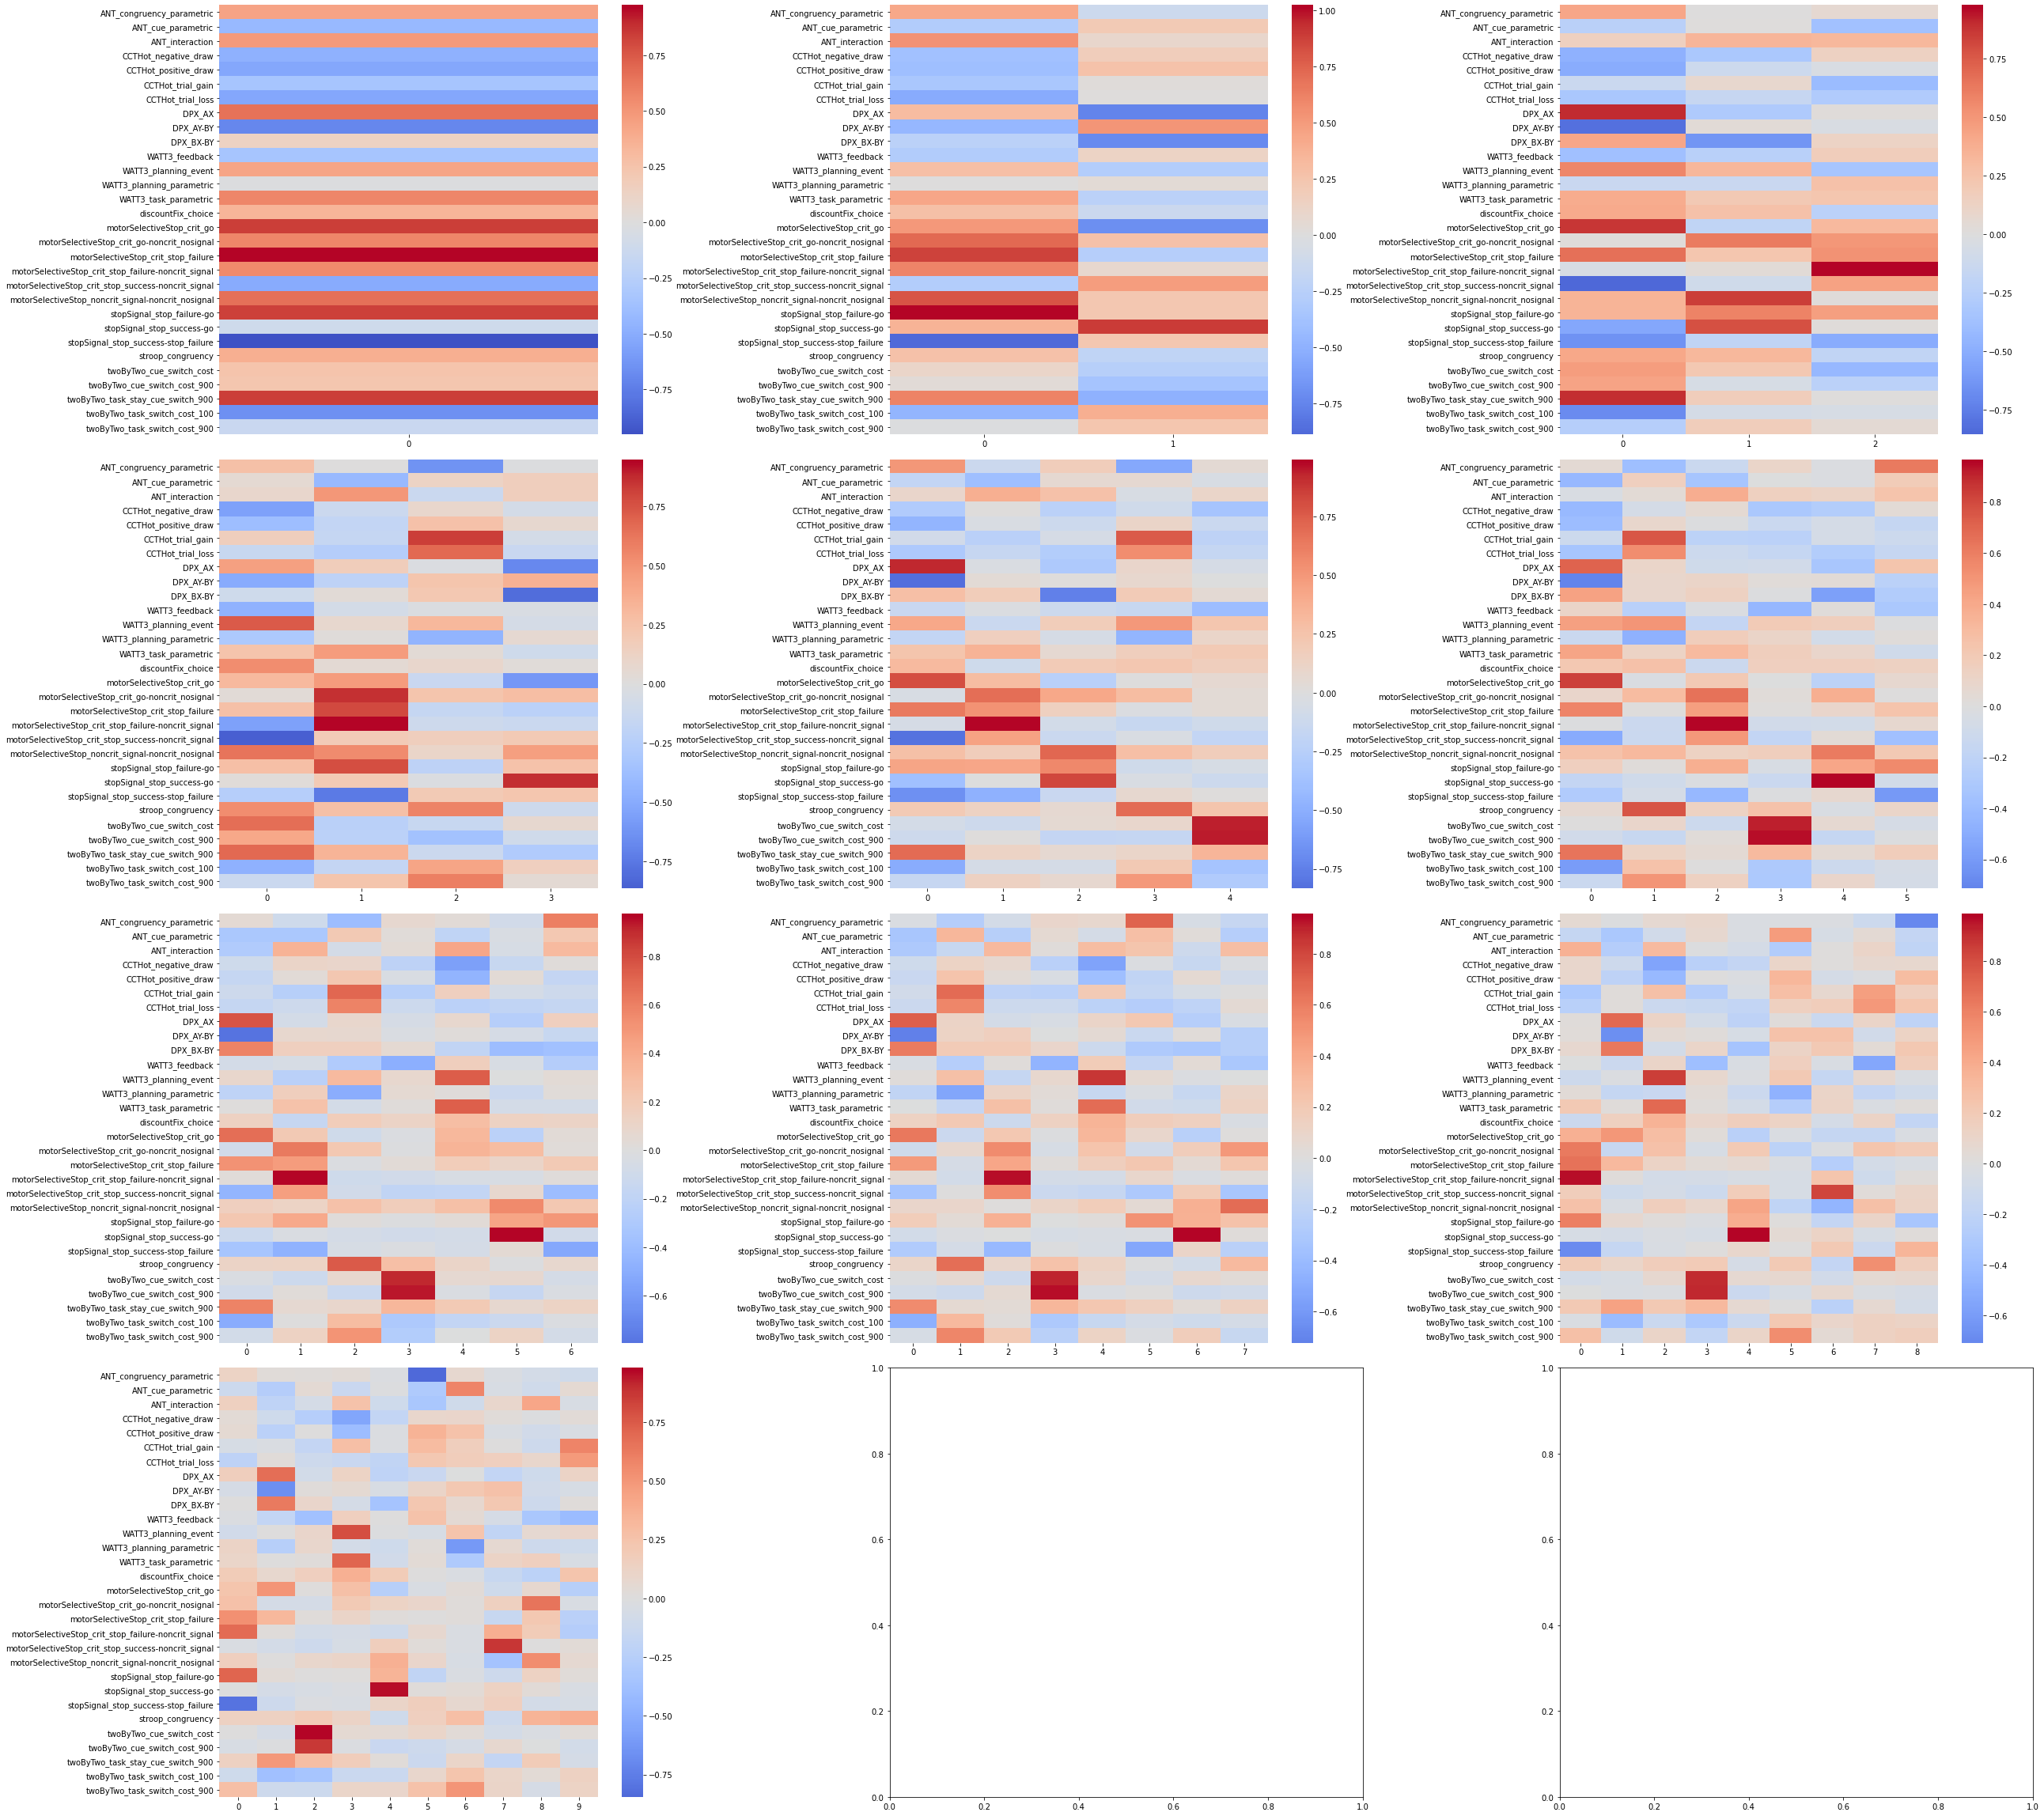

esfMRI [10] [364.82716655]
400 [10] [213.1431383]
1000 [10] [2593.3412623]


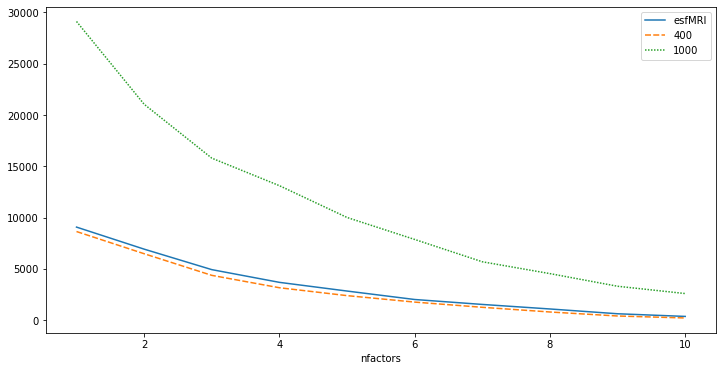

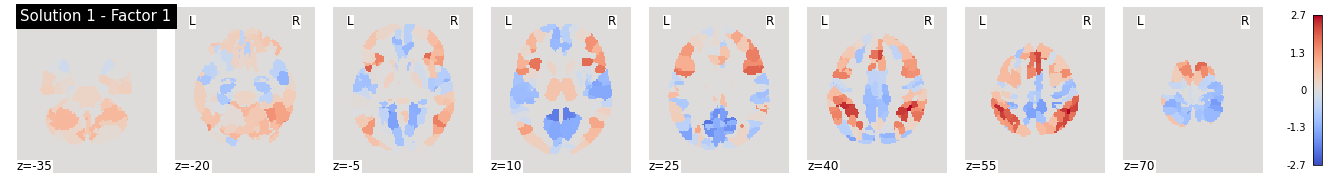

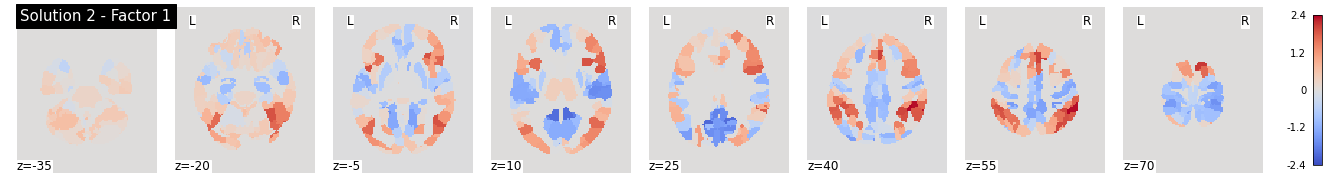

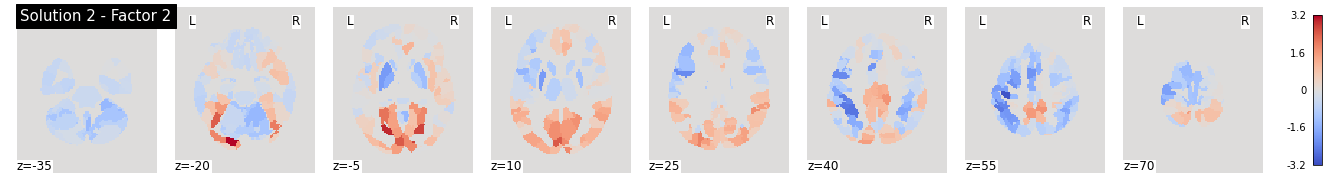

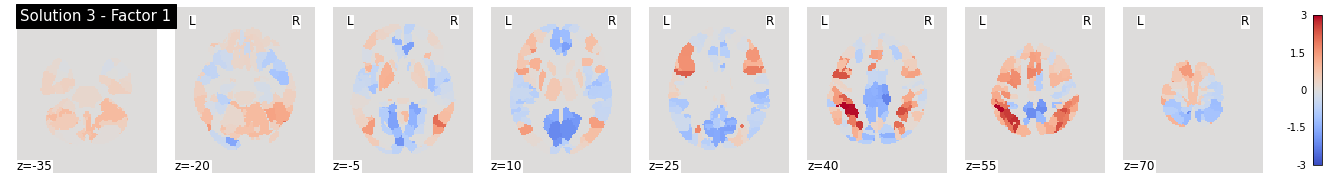

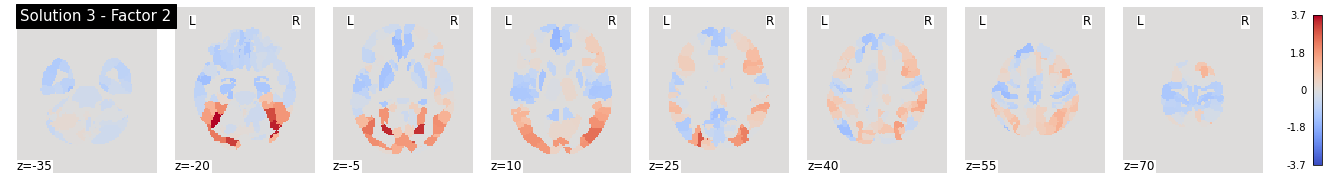

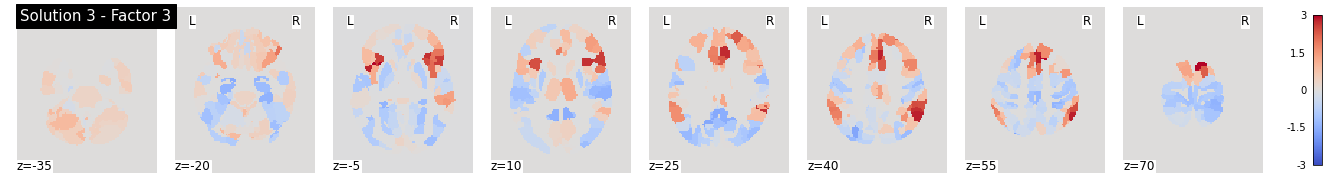

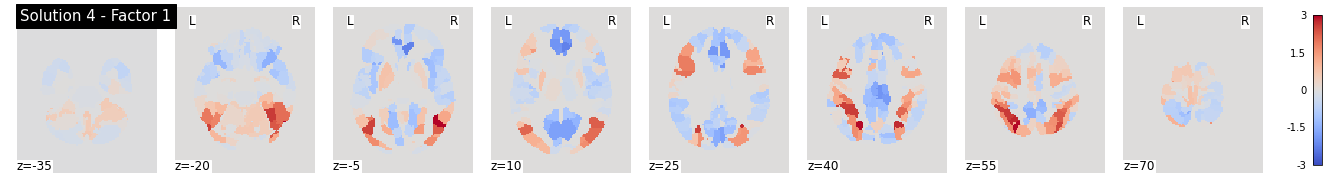

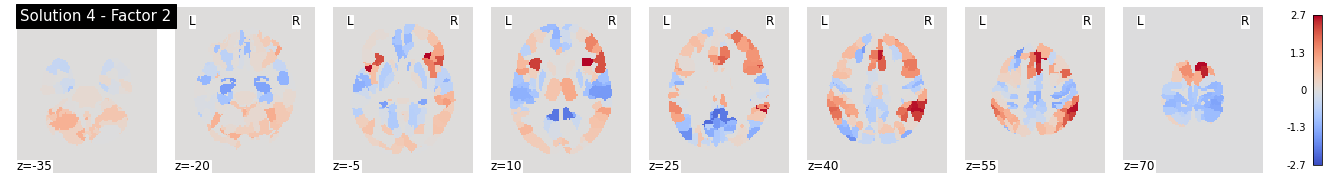

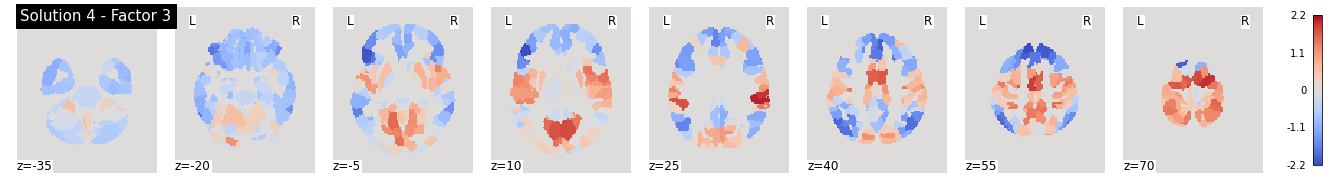

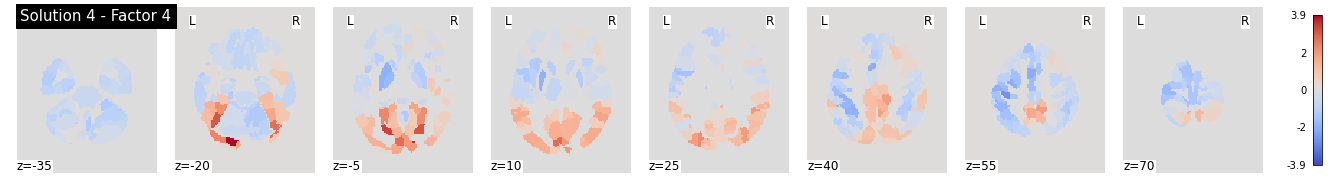

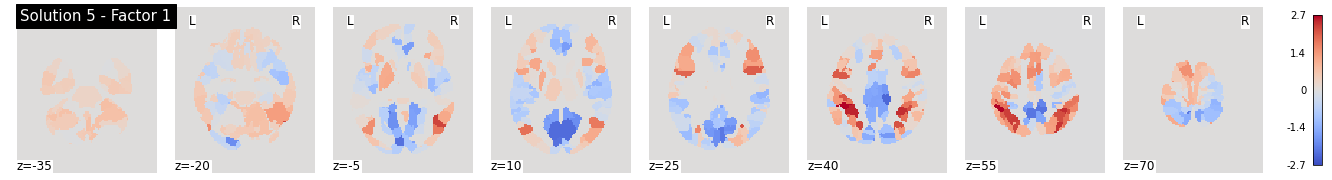

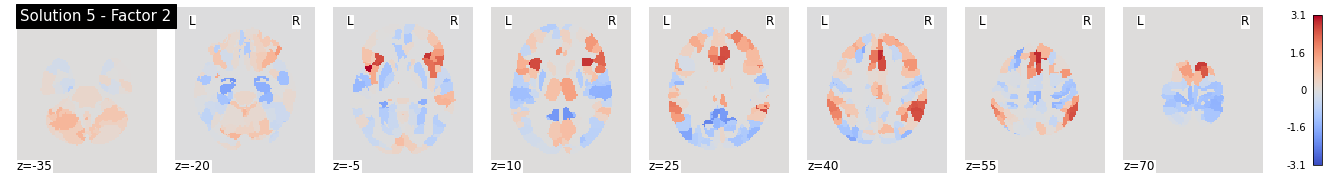

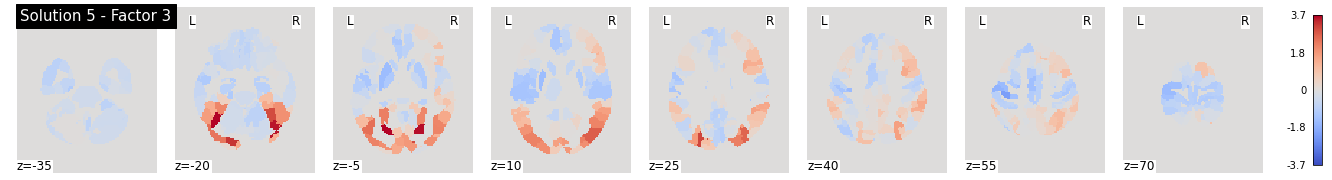

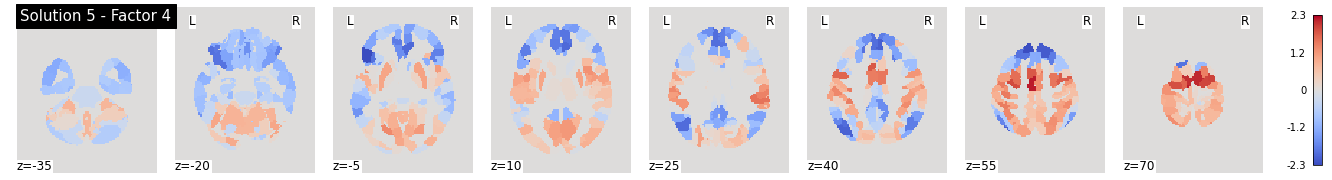

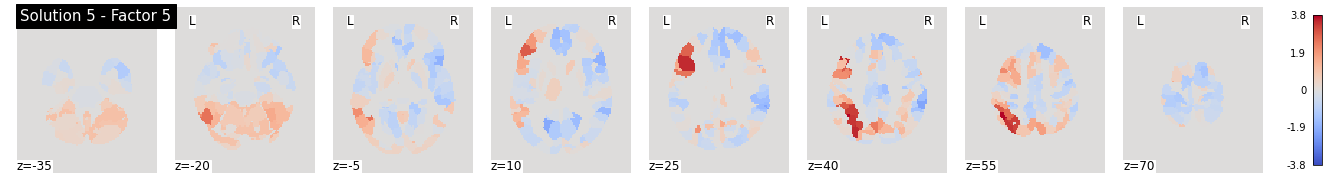

In [13]:
info_dict, BIC_df = pipeline(ALL_MAPS_NO_TASK_NO_RT)

# RT MAPS

****************************************
** Successfully transformed 0 positively skewed variables:
****************************************
Dropping 0 positively skewed data that could not be transformed successfully:
****************************************
** Successfully transformed 0 negatively skewed variables:
****************************************
Dropping 0 negatively skewed data that could not be transformed successfully:
****************************************
Dropping 4 contrasts which were correlated above 0.85
twoByTwo_RT	motorSelectiveStop_noncrit_nosignal_RT	WATT3_acting_RT	CCTHot_subsequent_RT


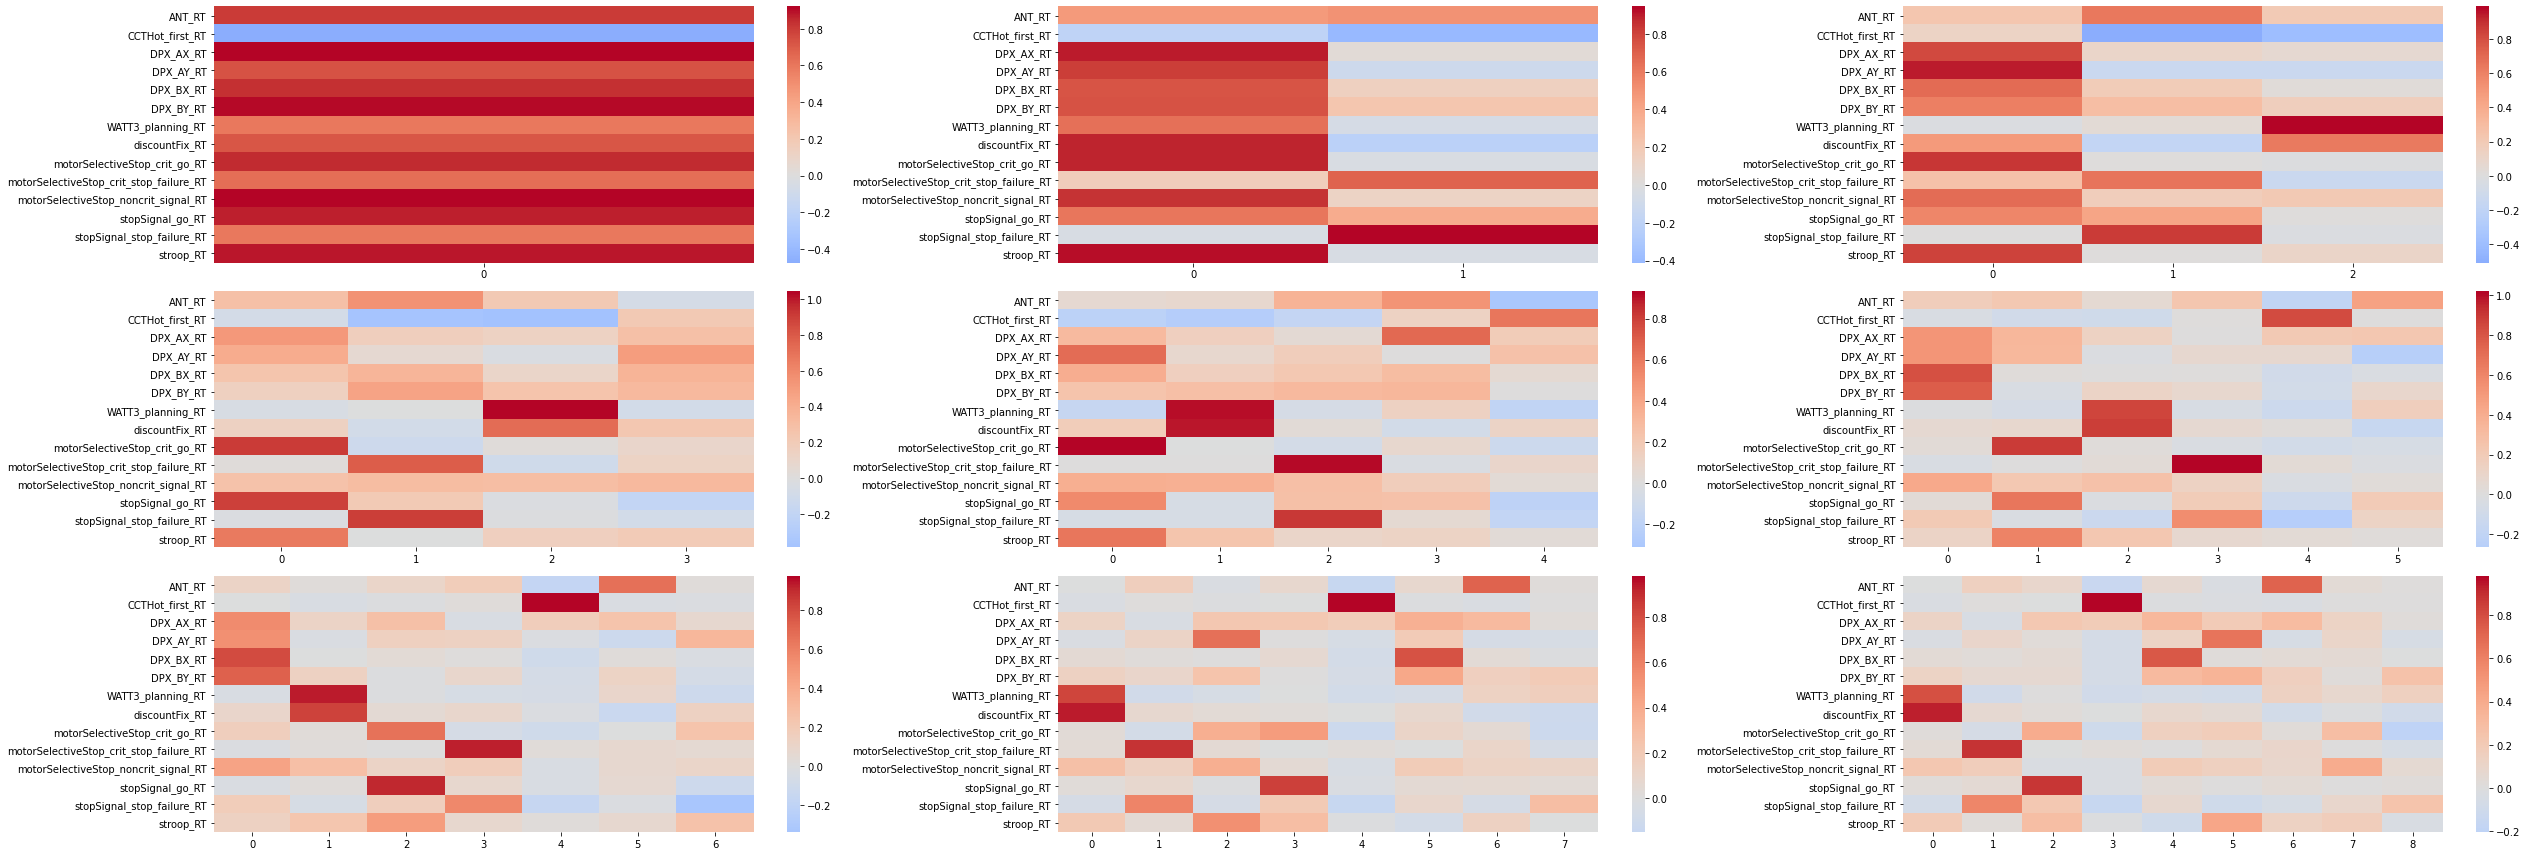

esfMRI [7] [-34.46576997]
400 [7] [-28.94641666]
1000 [9] [-17.40360737]


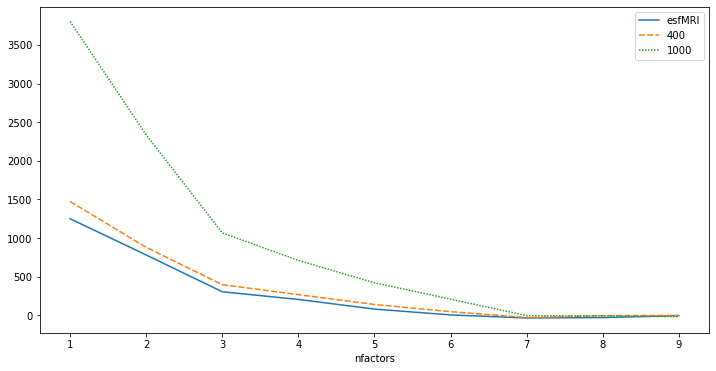

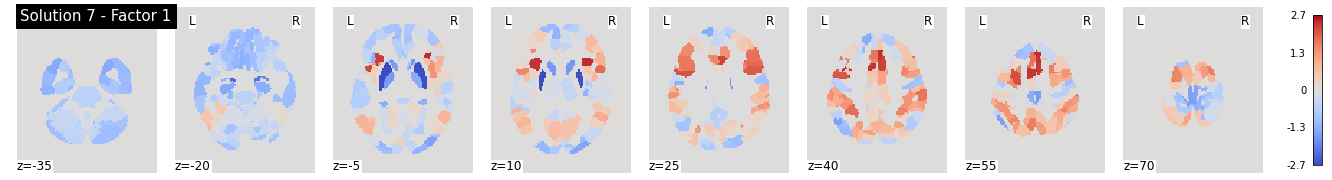

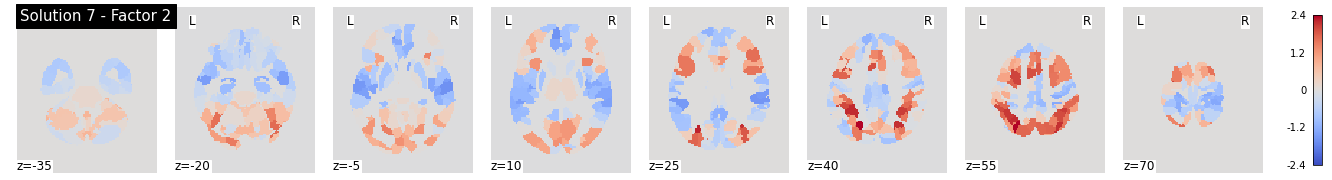

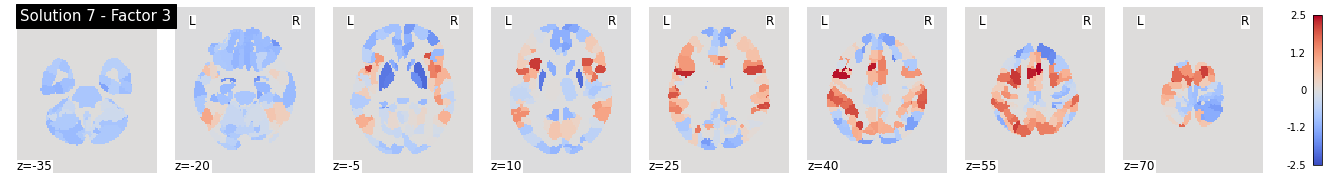

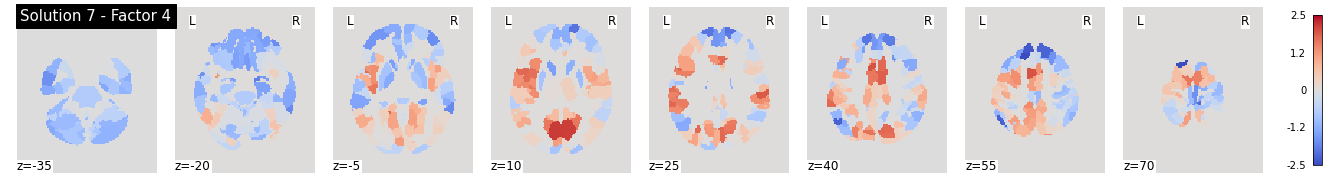

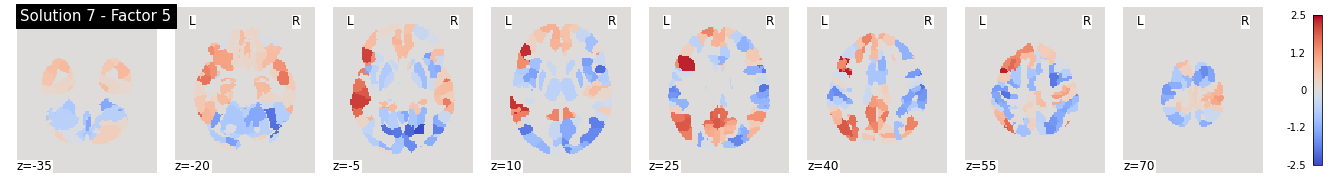

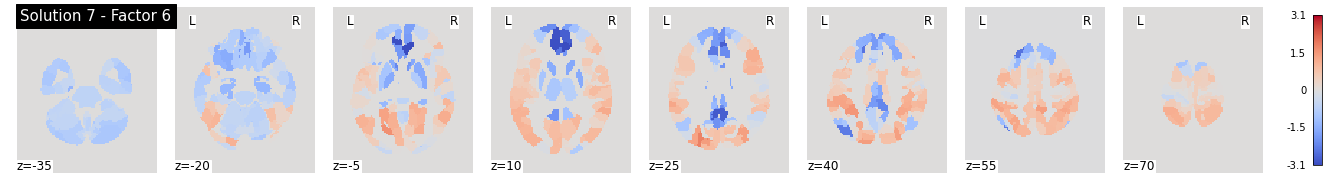

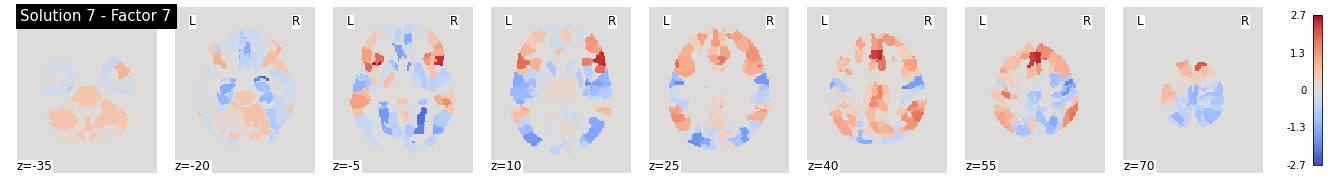

In [14]:
info_dict, BIC_df = pipeline(RT_MAPS, factor_options=np.arange(1,15,1), nfac_plot=[7])